# Machine Learning - Assignment 2

## Decision tree induction algorithm for classification tasks

The aim of the assignment is to:

* Implement a decision tree induction algorithm for classification tasks.
* Make sure it works for real valued features and nominal features (categorical features without rank, e.g., red - blue - green).
* Test the algorithm on 3 datasets.

Follow the instructions and implement what is missing to complete the assignment. Some functions have been started to help you a little bit with the inputs or outputs of the function.

**Note:** You might need to go back and forth during your implementation of the code. The structure is set up to make implementation easier, but how you return values from the different functions might vary, and you might find yourself going back and change something to make it easier later on.

## Assignment preparations

We help you out with importing the libraries.

**IMPORTANT NOTE:** You may not import any more libraries than the ones already imported!

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Decision tree model

The main objective is to implement the decision tree model. The implemented decision tree needs to be recursive model, that is, it should be implemented general enough to call itself in order to grow. "Growing" a tree refers to the same thing as "training" a model.

As said in the introduction, the structure is set up to help with implementation, but the nature of this model makes it a bit harder to implement function-by-function. You will most likely go back and forth between these first tasks.

### 1) Grow Tree

We will start with the main function of the decision tree, the "growing" function. 

This function should be called when creating the model, but also from inside itself. It is responible for creating all the nodes and leafs in the tree.

In [22]:
def grow_tree(data, target, depth=0, max_depth=None, min_samples_split=2, imbalance_threshold=0.95):

    # TODO: Implement the rest of this function.
    # NOTE: You will need to come back to this function to make use of later functions.
    
    if stop1(target):
        return {'leaf': True, 'class': target.iloc[0]}
    
    if stop2(depth, max_depth):
        return {'leaf': True, 'class': target.mode().iloc[0]}
    
    if stop3(data, min_samples_split):
        return {'leaf': True, 'class': target.mode().iloc[0]}
    
    if stop4(data, imbalance_threshold):
        return {'leaf': True, 'class': target.mode().iloc[0]}
    
    best_feature, best_threshold = find_best_split(data, target)
    
    if best_feature is None:
        return {'leaf': True, 'class': target.mode().iloc[0]}

    if data[best_feature].dtype.name == "category":
        left_mask = data[best_feature] == best_threshold
        right_mask = ~left_mask
    else:
        left_mask = data[best_feature] < best_threshold
        right_mask = ~left_mask

    left_subtree = grow_tree(data[left_mask], target[left_mask], depth + 1, max_depth)
    right_subtree = grow_tree(data[right_mask], target[right_mask], depth + 1, max_depth)

    return {
        'leaf': False,
        'feature': best_feature,
        'threshold': best_threshold,
        'left': left_subtree,
        'right': right_subtree
    }

### 2) Growth stopping conditions (or stopping criterias)

The "grow_tree" function needs some way of stop growing, otherwise it will grow indefinitely. We will adress this issue here.

The trees stopping criterias needs to handle the following:

1) When a node has only datapoints of a single class.

2) Prevent the tree from growing to large, i.e., a max depth.

3) Prevent the tree nodes from becoming to small.

4) Prevent the tree from growing when the node is large (has a lot of datapoints) but it is very unbalanced. This is an extention to case 1.

Can you think of some other stopping criterias that is good to have? 

In [23]:
# TODO: Change the name of the functions and implement them as you see fit.

def stop1(target):
    return len(np.unique(target)) == 1

def stop2(depth, max_depth):
    return max_depth is not None and depth >= max_depth

def stop3(data, min_samples_split):
    return len(data) < min_samples_split

def stop4(target, imbalance_threshold=0.95):
    class_counts = target.value_counts(normalize=True)
    return class_counts.max() >= imbalance_threshold

# Add more stopping criterias if needed. Don't forget to use them when growing the tree!

### 3) Best feature for splitting nodes

When we are growing the tree, we need to decide how we are going to split a node into two new nodes. This is achived by looking at the features of the data in the node and calculate the best feature to split on.

Here you have a choice:

* Split using **Information Entropy**
* Split using **Gini Impurity**

Finish the function below using Information Entropy or Gini Impurity.

**Note:** Your code should be able to handle both real and categorical features!

In [ ]:
# TODO: Change the name to which ever you chose.
def entropy(target):
    values, counts = np.unique(target, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))
    # TODO: Implement the rest of this function.
    # NOTE: Do not forget to have support for real and categorical features.

def information_gain(data, target, feature, threshold):
    parent_entropy = entropy(target)
    
    if data[feature].dtype in ['object', 'category']:
        left_mask = data[feature] == threshold
        right_mask = ~left_mask
    else:
        left_mask = data[feature] < threshold
        right_mask = ~left_mask
    
    left_entropy = entropy(target[left_mask])
    right_entropy = entropy(target[right_mask])
    
    left_weight = len(data[left_mask]) / len(data)
    right_weight = len(data[right_mask]) / len(data)
    
    gain = parent_entropy - (left_weight * left_entropy + right_weight * right_entropy)
    return gain

def find_best_split(data, target):
    best_feature = None
    best_threshold = None
    best_gain = 0

    for feature in data.columns:
        thresholds = data[feature].unique()
        for threshold in thresholds:
            gain = information_gain(data, target, feature, threshold)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold
            
    return best_feature, best_threshold

### 4) Split data

When growing the tree, we need to split the data multiple times, and what we decide to split varies a lot. It is similar to splitting data into train and test sets (remember from assignment 1), but we split the data based on the best feature for growing a good tree.

**IMPORTANT NOTE:** To calculate binary splits for real-valued features, the following rule must be applied: an instance with a feature value lower than the mean feature value follows the left edge from the split node while all other instances follow the right edge from the split node.

In [ ]:
def split_data(data, target, feature, threshold):
    # TODO: Implement the rest of this function.
    if data[feature].dtype in ['object', 'category']:
        left_mask = data[feature] == threshold
        right_mask = ~left_mask
    else:
        left_mask = data[feature] < float(threshold)
        right_mask = ~left_mask
    left_data, left_target = data[left_mask], target[left_mask]
    right_data, right_target = data[right_mask], target[right_mask]
    return left_data, left_target, right_data, right_target

### 5) Predict with tree model

Finally, when we have grown our tree, we would like to use it for prediction. When using the tree for prediction, we traverse the tree for each datapoint untill we land in a leaf node.

In [26]:
def predict_with_tree(tree, sample):

    # TODO: Implement the rest of this function.
    # NOTE: This function should also be recursive.
    if tree['leaf']:
        return tree['class']
    
    feature = tree['feature']
    threshold = tree['threshold']
    
    if isinstance(sample[feature], (str, pd.Categorical)):
        if sample[feature] == threshold:
            return predict_with_tree(tree['left'], sample)
        else:
            return predict_with_tree(tree['right'], sample)
    else:
        if sample[feature] < threshold:
            return predict_with_tree(tree['left'], sample)
        else:
            return predict_with_tree(tree['right'], sample)

## Test decision tree model, compare with scikit learn, and plot dataset results

In the last part of the lab, you are going to test your tree code and compare it to scikit learn. The goal is not to be better than an established library, but to give you an indication about if you are on the right track.

You will need to plot the results from your model and the scikit learn model using matplotlib. We suggest a simple but informative bar-charts.

To make the comparison fair, you should train and test both your decision tree algorithm and the scikit learn at least 5 times, and shuffle the data each time before splitting the data into a train and test set.

The datasets are:

* Wine - (https://archive.ics.uci.edu/dataset/109/wine)
* Heart disease - (https://archive.ics.uci.edu/dataset/45/heart+disease)
* Car - (https://archive.ics.uci.edu/dataset/19/car+evaluation)

**IMPORTANT NOTE 1:** Take note of the feature types in the datasets, some features are numerical in value but are in fact categorical features. Be sure to handle these features correctly!

**IMPORTANT NOTE 2:** In this assignment it helps to add an additional header with information about the features and if they are nominal (n) or real (r) features.

In [27]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

You may use the "**accuracy_score**" function from scikit learn (imported above) to compare the performance of your own and scikit learns models.

See below for an example use.

In [28]:
y_true = [1,1,1,1,1] # Pretend labels
y_pred = [1,1,2,2,1] # Pretend prediction

accuracy_score(y_true, y_pred)

0.6

### 6) Dataset 1: Wine

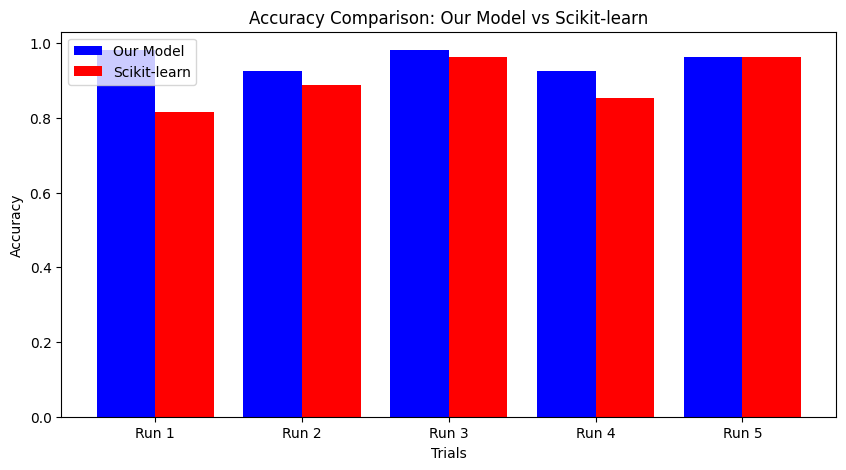

In [34]:
data_wine = pd.read_csv("wine.csv")
# TODO: Set up the data and split it into train and test-sets.
data_wine = data_wine.iloc[1:].reset_index(drop=True)
X = data_wine.iloc[:, :-1].astype(float)
y = data_wine.iloc[:, -1].astype(int)

X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

n_tests = 5

model_scores = []
sklearn_model_scores = []

for _ in range(n_tests):
# TODO: Train and test your implemented tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=None)
    
    X_train = pd.DataFrame(X_train, columns=data_wine.columns[:-1])
    X_test = pd.DataFrame(X_test, columns=data_wine.columns[:-1])
    
    tree = grow_tree(X_train, y_train, max_depth=5)
    
    y_pred_our_model = [predict_with_tree(tree, sample) for _, sample in X_test.iterrows()]
    
    our_model_accuracy = accuracy_score(y_test, y_pred_our_model)
    model_scores.append(our_model_accuracy)
    
# TODO: Train and test scikit learns tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model
    clf = DecisionTreeClassifier(max_depth=5)
    clf.fit(X_train, y_train)
    
    y_pred_sklearn = clf.predict(X_test)
    
    sklearn_accuracy = accuracy_score(y_test, y_pred_sklearn)
    
    sklearn_model_scores.append(sklearn_accuracy)
# TODO: Do the above at least 5 times
# NOTE: Use loops here!

# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough
plt.figure(figsize=(10, 5))
x_labels = [f"Run {i+1}" for i in range(n_tests)]
x = np.arange(n_tests)

plt.bar(x - 0.2, model_scores, 0.4, label="Our Model", color="blue")
plt.bar(x + 0.2, sklearn_model_scores, 0.4, label="Scikit-learn", color="red")

plt.xlabel("Trials")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: Our Model vs Scikit-learn")
plt.xticks(x, x_labels)
plt.legend()
plt.show()

### 7) Dataset 2: Heart Disease

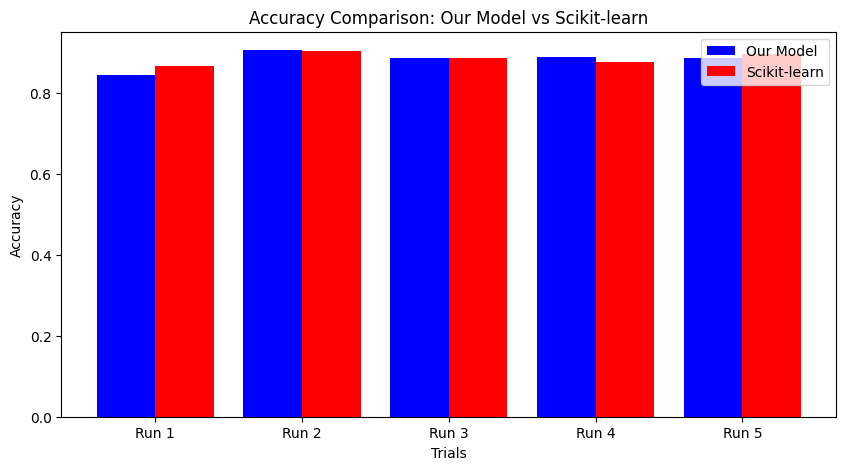

In [30]:
data_heart = pd.read_csv("heart.csv")
# TODO: Set up the data and split it into train and test-sets.
X = data_heart.iloc[:, :-1].astype(float)
y = data_heart.iloc[:, -1].astype(int)

X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

n_tests = 5

model_scores = []
sklearn_model_scores = []

for _ in range(n_tests):
# TODO: Train and test your implemented tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=None)
    
    X_train = pd.DataFrame(X_train, columns=data_heart.columns[:-1])
    X_test = pd.DataFrame(X_test, columns=data_heart.columns[:-1])
    
    tree = grow_tree(X_train, y_train, max_depth=5)
    y_pred_our_model = [predict_with_tree(tree, sample) for _, sample in X_test.iterrows()]
    
    model_scores.append(accuracy_score(y_test, y_pred_our_model))
    
# TODO: Train and test scikit learns tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model
    clf = DecisionTreeClassifier(max_depth=5)
    clf.fit(X_train, y_train)
    
    y_pred_sklearn = clf.predict(X_test)
    
    sklearn_accuracy = accuracy_score(y_test, y_pred_sklearn)
    
    sklearn_model_scores.append(sklearn_accuracy)
# TODO: Do the above at least 5 times
# NOTE: Use loops here!

# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough
plt.figure(figsize=(10, 5))
x_labels = [f"Run {i+1}" for i in range(n_tests)]
x = np.arange(n_tests)

plt.bar(x - 0.2, model_scores, 0.4, label="Our Model", color="blue")
plt.bar(x + 0.2, sklearn_model_scores, 0.4, label="Scikit-learn", color="red")

plt.xlabel("Trials")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: Our Model vs Scikit-learn")
plt.xticks(x, x_labels)
plt.legend()
plt.show()

### 8) Dataset 3: Car

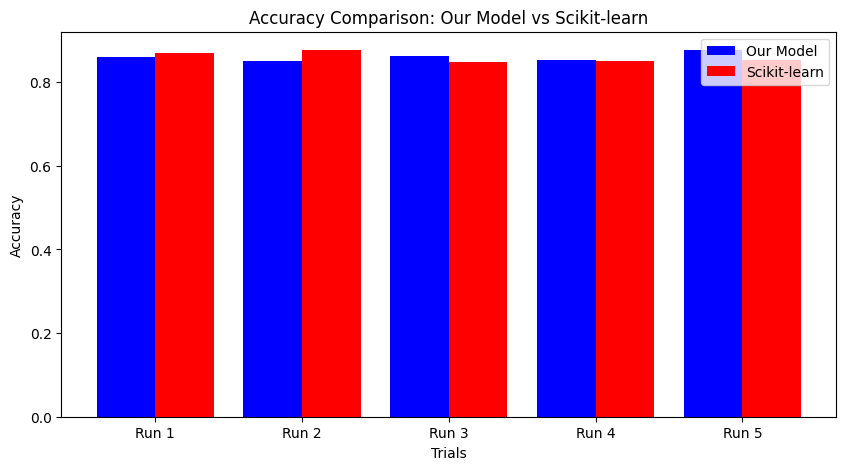

In [59]:
data_car = pd.read_csv("car.csv")
# TODO: Set up the data and split it into train and test-sets.

X = data_car.iloc[:, :-1].copy()
y = data_car.iloc[:, -1]

for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category')
y = y.astype('category')

n_tests = 5

model_scores = []
sklearn_model_scores = []

for _ in range(n_tests):
# TODO: Train and test your implemented tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=None)
    
    tree = grow_tree(X_train, y_train, max_depth=5)
    y_pred_our_model = [predict_with_tree(tree, sample) for _, sample in X_test.iterrows()]
    
    model_scores.append(accuracy_score(y_test, y_pred_our_model))

# TODO: Train and test scikit learns tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model
    X_train = X_train.apply(lambda col: col.cat.codes)
    X_test = X_test.apply(lambda col: col.cat.codes)

    clf = DecisionTreeClassifier(max_depth=5)
    clf.fit(X_train, y_train)
    
    y_pred_sklearn = clf.predict(X_test)
    
    sklearn_accuracy = accuracy_score(y_test, y_pred_sklearn)
    
    sklearn_model_scores.append(sklearn_accuracy)
# TODO: Do the above at least 5 times
# NOTE: Use loops here!

# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough
plt.figure(figsize=(10, 5))
x_labels = [f"Run {i+1}" for i in range(n_tests)]
x = np.arange(n_tests)

plt.bar(x - 0.2, model_scores, 0.4, label="Our Model", color="blue")
plt.bar(x + 0.2, sklearn_model_scores, 0.4, label="Scikit-learn", color="red")

plt.xlabel("Trials")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: Our Model vs Scikit-learn")
plt.xticks(x, x_labels)
plt.legend()
plt.show()

### 9) Training with normalized data on the wine-dataset

So far, we have trained our decision trees with "raw" data, i.e., we haven't done much preprocessing on the data.

Here we will do minor preprocessing on the data with the help of the scikit-learn library: https://scikit-learn.org/stable/modules/preprocessing.html

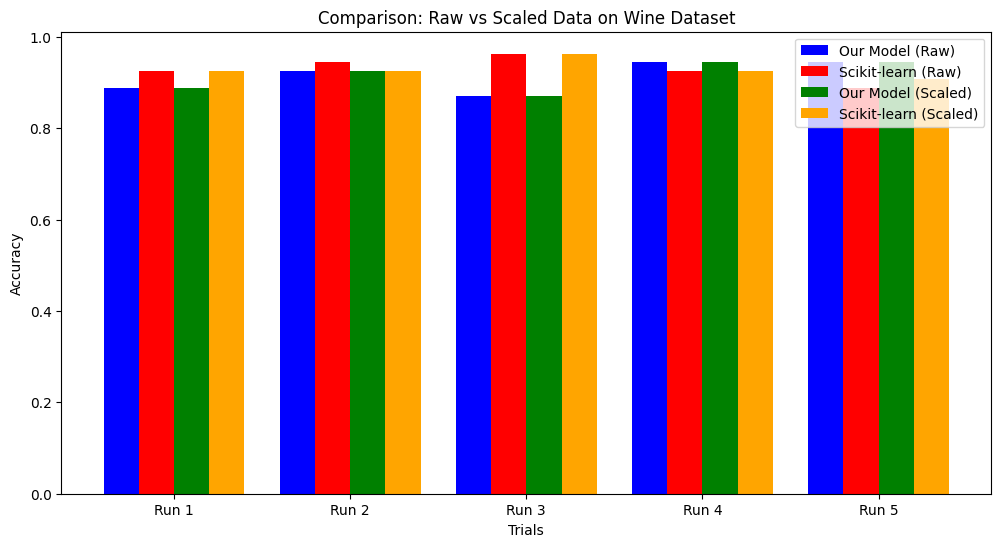

In [58]:
from sklearn import preprocessing

# TODO: Use the wine dataset from above and scale its features and labels between 0 and 1
data_wine = pd.read_csv("wine.csv")
data_wine = data_wine.iloc[1:].reset_index(drop=True)

X = data_wine.iloc[:, :-1].astype(float)
y = data_wine.iloc[:, -1].astype(int)

scaler = preprocessing.StandardScaler()

# X_scaled = scaler.fit_transform(X)

n_tests = 5

# TODO: Run the code from the dataset and compare the preprocessed vs non-preprocessed data.
# NOTE: You can copy most of the workflow from the dataset code above to save you some time.
# NOTE: Use the same train/test split for your tree model for both the preprocessed vs non-preprocessed data.

raw_model_scores = []
raw_sklearn_model_scores = []
scaled_model_scores = []
scaled_sklearn_model_scores = []

for i in range(n_tests):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=None)
    # X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, random_state=None)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train_scaled = y_train
    y_test_scaled = y_test

    X_train = pd.DataFrame(X_train, columns=data_wine.columns[:-1]).reset_index(drop=True)
    X_test = pd.DataFrame(X_test, columns=data_wine.columns[:-1]).reset_index(drop=True)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=data_wine.columns[:-1]).reset_index(drop=True)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=data_wine.columns[:-1]).reset_index(drop=True)

    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    tree = grow_tree(X_train, y_train, max_depth=5)
    y_pred_our_model = [predict_with_tree(tree, sample) for _, sample in X_test.iterrows()]
    our_model_accuracy = accuracy_score(y_test, y_pred_our_model)
    raw_model_scores.append(our_model_accuracy)

    clf = DecisionTreeClassifier(max_depth=5)
    clf.fit(X_train, y_train)
    y_pred_sklearn = clf.predict(X_test)
    sklearn_accuracy = accuracy_score(y_test, y_pred_sklearn)
    raw_sklearn_model_scores.append(sklearn_accuracy)

    tree_scaled = grow_tree(X_train_scaled, y_train, max_depth=5)
    y_pred_scaled = [predict_with_tree(tree_scaled, sample) for _, sample in X_test_scaled.iterrows()]
    our_model_scaled_accuracy = accuracy_score(y_test, y_pred_scaled)
    scaled_model_scores.append(our_model_scaled_accuracy)

    clf_scaled = DecisionTreeClassifier(max_depth=5)
    clf_scaled.fit(X_train_scaled, y_train)
    y_pred_sklearn_scaled = clf_scaled.predict(X_test_scaled)
    sklearn_scaled_accuracy = accuracy_score(y_test, y_pred_sklearn_scaled)
    scaled_sklearn_model_scores.append(sklearn_scaled_accuracy)

# TODO: Do the above at least 5 times
# NOTE: Use loops here!

# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough
plt.figure(figsize=(12, 6))
x_labels = [f"Run {i+1}" for i in range(n_tests)]
x = np.arange(n_tests)

plt.bar(x - 0.3, raw_model_scores, 0.2, label="Our Model (Raw)", color="blue")
plt.bar(x - 0.1, raw_sklearn_model_scores, 0.2, label="Scikit-learn (Raw)", color="red")
plt.bar(x + 0.1, scaled_model_scores, 0.2, label="Our Model (Scaled)", color="green")
plt.bar(x + 0.3, scaled_sklearn_model_scores, 0.2, label="Scikit-learn (Scaled)", color="orange")

plt.xlabel("Trials")
plt.ylabel("Accuracy")
plt.title("Comparison: Raw vs Scaled Data on Wine Dataset")
plt.xticks(x, x_labels)
plt.legend()
plt.show()

# Questions for examination:

In addition to completing the assignment with all its tasks, you should also prepare to answer the following questions:

1) Why is growing the tree indefinitely such a bad idea? The performance would increase would it not?

2) Beside preventing the tree from growing to large, what is the purpose of 'stopping criterias'?

3) What is the difference between **Information Entropy** and **Gini Impurity**?

4) What are some pros about using decision trees?

5) Did preprocessing the data help with performance when using decision trees?

# Finished!

Was part of the setup incorrect? Did you spot any inconsistencies in the assignment? Could something improve?

If so, please write them and send via email and send it to:

* marcus.gullstrand@ju.se

Thank you!